## Import required libraries

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

## Input scan folder

In [2]:
#proposal = '20250420' # Only needed when working on MAXIV cloud
#visit = '2025090908' # Only needed when working on MAXIV cloud
scan ='62739'
DataFolder = f'Data/scan-{scan}'


if os.path.isdir(DataFolder):
    print(f'Folder exists:{DataFolder}')
    num_files= len([f for f in os.listdir(DataFolder)])
    print(f'Number of files: {num_files}')
else:
    print('Folder does not exist')


Folder exists:Data/scan-62739
Number of files: 1662


## Plot intensity vs. elution time

Choose to sum or average over a certain q range

%matplotlib inline  Default non-interactive plot

%matplotlib widget  Interactive plot, requires 'ipympl' package to be installed

Text(0, 0.5, 'Average intensity 0.01<q<0.08')

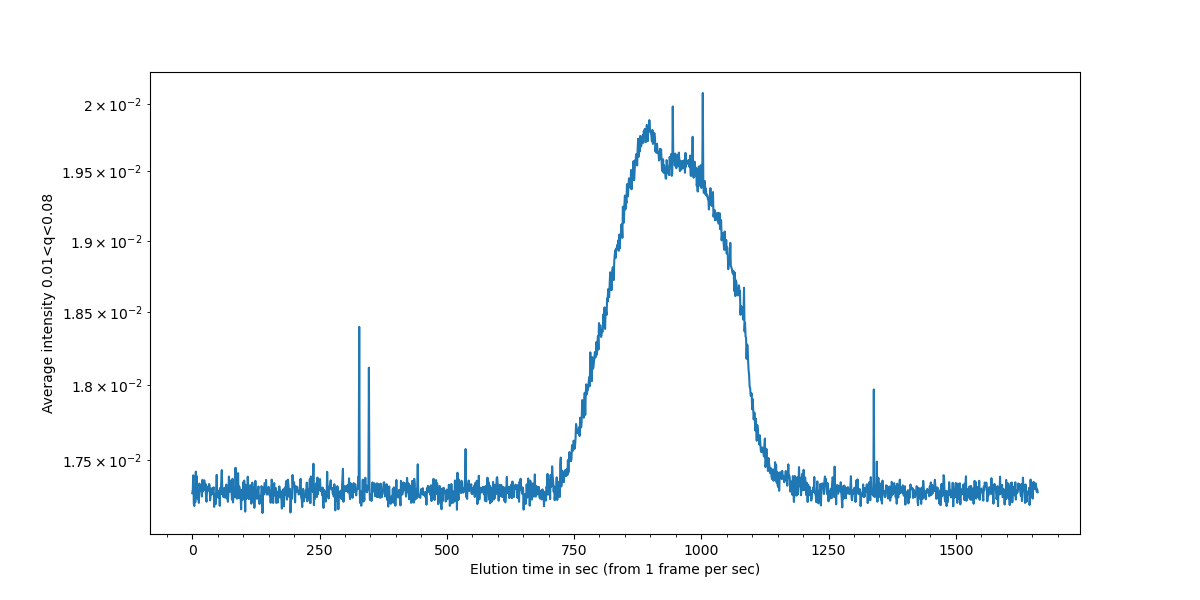

In [3]:
%matplotlib widget
import matplotlib.pyplot as plt




# q-range for summing/averaging
q_min = 0.01
q_max = 0.08

# Plot sum of intensity
intensities = []

for scan in range(num_files): # For every shot/file in the folder
    data = np.loadtxt(f'{DataFolder}/shot_{scan:04d}_eiger.dat')   # Change this to the format of your data files, mine has the detector name after the shot number
    dataq = data[:,0]
    dataI = data[:,1]
    mask = (dataq <= q_max) & (dataq >= q_min) # Mask for the desired q-range
    avg_intensity = np.sum(dataI[mask])/len(data[:,0])
    #sum_intensity = np.sum(dataI[mask]) # Toggle to choose between sum or average
    intensities.append(avg_intensity)
    #intensities.append(sum_intensity)   # Toggle to choose between sum or average

plt.figure(figsize=(12,6))
plt.plot(range(num_files), intensities)
plt.yscale('log')
plt.gca().minorticks_on()
plt.xlabel('Elution time in sec (from 1 frame per sec)')
plt.ylabel(f'Average intensity {q_min}<q<{q_max}')


## Merge frames and average intensity and error

merged / averaged I calculated by:
$$I_{merged} = \frac{\sum I}{number~of~frames}$$
$$Err_{merged}~or~\sigma= \frac{\sqrt{\sum \sigma^2}}{number~of~frames}$$

In [ ]:
from functions import merge_frames

Buffer_start = 500
Buffer_end = 600  # First and last frame of buffer region (it will include the last frame since +1 is added in the function call)

Buffer_q, Buffer_I, Buffer_err, Buffer_count = merge_frames(DataFolder, Buffer_start, Buffer_end+1)

print(f'Number of buffer frames merged: {Buffer_count}')

Number of buffer frames merged: 101


In [10]:
from functions import merge_frames

Sample_start = 950 
Sample_end = 957   # First and last frame of sample region (it will include the last frame since +1 is added in the function call)
Sample_q, Sample_I, Sample_err, Sample_count = merge_frames(DataFolder, Sample_start, Sample_end+1)

print(f'Number of sample frames merged: {Sample_count}')

Number of sample frames merged: 8


## Subtract solvent/buffer from sample

Calculated by:
$$ I_{sub} = I_{sample}-I_{buffer}$$
$$ Err_{sub} = \sqrt{\sigma_{sample}^2 + \sigma_{buffer}^2} $$

In [11]:
subtracted_q = Sample_q
subtracted_I = Sample_I - Buffer_I
subtracted_err = np.sqrt(Sample_err**2 + Buffer_err**2)

## Plot

Text(0, 0.5, 'I (1/cm)')

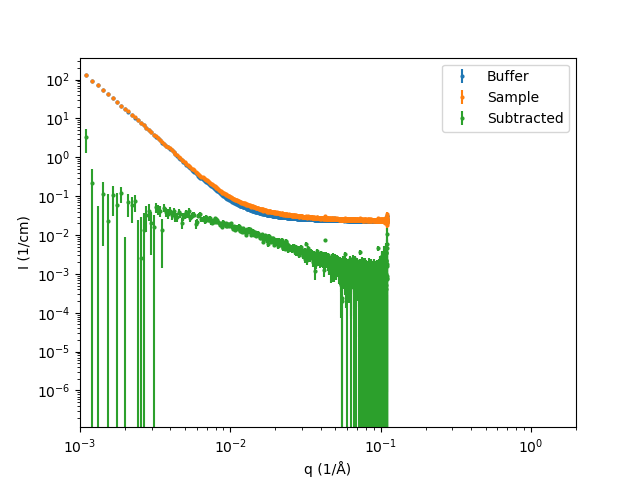

In [12]:
plt.figure()

plt.errorbar(Buffer_q, Buffer_I, yerr=Buffer_err, fmt='o', markersize=2, label='Buffer')
plt.errorbar(Sample_q, Sample_I, yerr=Sample_err, fmt='o', markersize=2, label='Sample')
plt.errorbar(subtracted_q, subtracted_I, yerr=subtracted_err, fmt='o', markersize=2, label='Subtracted')


plt.legend()
plt.xscale('log')
plt.xlim(1e-03, 2)
plt.yscale('log')
plt.xlabel('q (1/Å)')
plt.ylabel('I (1/cm)')

## Save data
def save_data (item_name, start_frame, end_frame, q_values, intensity_values, propagated_err):


In [15]:
from functions import save_data

save_data(scan ,'sample_1', Sample_start, Sample_end, Sample_q, Sample_I, Sample_err)
save_data(scan ,'buffer_1', Buffer_start, Buffer_end, Buffer_q, Buffer_I, Buffer_err)
save_data(scan ,'sample_1_subtracted_1', Sample_start, Sample_end, subtracted_q, subtracted_I, subtracted_err)

Data saved for shots 0950 to 0957 at Output/1661_sample_1_0950_0957.dat
Data saved for shots 0500 to 0600 at Output/1661_buffer_1_0500_0600.dat
Data saved for shots 0950 to 0957 at Output/1661_sample_1_subtracted_1_0950_0957.dat
